In [1]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
sys.path.append(base_path)

base_path: /home/toc3/press


In [ ]:
from functools import partial
from xgboost import XGBClassifier
from gplearn.genetic import SymbolicClassifier

In [ ]:
from express.databases import SQLiteDatabase
from express.datasets import PressingDataset
from express.components import press
from express.visualization import plot_action
from express.utils import add_names

In [5]:
TRAIN_DB_PATH = os.path.join(base_path, "stores/train_database.sqlite")
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")

train_db = SQLiteDatabase(TRAIN_DB_PATH)
test_db = SQLiteDatabase(TEST_DB_PATH)

print("train_db:", train_db)
print("test_db:", test_db)

train_db: <express.databases.sqlite.SQLiteDatabase object at 0x7fb9f74c4970>
test_db: <express.databases.sqlite.SQLiteDatabase object at 0x7fb933ca49d0>


In [6]:
dataset_train = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "train"))
dataset_test = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "test"))

print("dataset_train:", dataset_train)
print("dataset_test:", dataset_test)

dataset_train: functools.partial(<class 'express.datasets.PressingDataset'>, path='/home/toc3/press/stores/datasets/train')
dataset_test: functools.partial(<class 'express.datasets.PressingDataset'>, path='/home/toc3/press/stores/datasets/test')


In [8]:
train_dataset = PressingDataset(
    path= os.path.join(base_path, "stores", "datasets", "train"),
    xfns=["startlocation", "closest_11_players"],
    yfns=["counterpress"],
    load_cached=True,
    nb_prev_actions=3
)

test_dataset = PressingDataset(
    path= os.path.join(base_path, "stores", "datasets", "test"),
    xfns=["startlocation", "closest_11_players"],
    yfns=["counterpress"],
    load_cached=True,
    nb_prev_actions=3
)

In [11]:
nb_prev_actions_lst = ["0", "1", "2"] # current(0), previous(1), second_previous(2)
selected_features = ["startlocation", "closest_11_players"]# "extract_all_players"]

features = {}
label = ["counterpress"]

for xfn in train_dataset.xfns.items():
    key = xfn[0].__name__
    values = xfn[1]

    if key in selected_features:
        features[key] = [value for value in values if value[-1:] in nb_prev_actions_lst]

features

{'startlocation': ['start_x_a0',
  'start_y_a0',
  'start_x_a1',
  'start_y_a1',
  'start_x_a2',
  'start_y_a2'],
 'closest_11_players': ['teammate_1_x_a0',
  'teammate_1_y_a0',
  'teammate_1_distance_a0',
  'teammate_2_x_a0',
  'teammate_2_y_a0',
  'teammate_2_distance_a0',
  'teammate_3_x_a0',
  'teammate_3_y_a0',
  'teammate_3_distance_a0',
  'teammate_4_x_a0',
  'teammate_4_y_a0',
  'teammate_4_distance_a0',
  'teammate_5_x_a0',
  'teammate_5_y_a0',
  'teammate_5_distance_a0',
  'teammate_6_x_a0',
  'teammate_6_y_a0',
  'teammate_6_distance_a0',
  'teammate_7_x_a0',
  'teammate_7_y_a0',
  'teammate_7_distance_a0',
  'teammate_8_x_a0',
  'teammate_8_y_a0',
  'teammate_8_distance_a0',
  'teammate_9_x_a0',
  'teammate_9_y_a0',
  'teammate_9_distance_a0',
  'teammate_10_x_a0',
  'teammate_10_y_a0',
  'teammate_10_distance_a0',
  'opponent_1_x_a0',
  'opponent_1_y_a0',
  'opponent_1_distance_a0',
  'opponent_2_x_a0',
  'opponent_2_y_a0',
  'opponent_2_distance_a0',
  'opponent_3_x_a0',


In [ ]:
xgb=XGBClassifier(
    tree_method='gpu_hist', n_jobs=-1, verbosity=0, eval_metric="logloss"
    # you probably want to do some hyperparameter tuning here to get a good model
)

param_grid = {
    'n_estimators': [100, 200],  # 자주 사용되는 값만 남김
    'max_depth': [4, 6],  # 적당히 깊이를 조정
    'learning_rate': [0.05, 0.1],  # 안정적인 학습률
    'subsample': [0.8, 1.0],  # 대표적인 두 값
    'colsample_bytree': [0.8, 1.0],  # 중요한 두 값
    'min_child_weight': [1, 3]  # 자주 사용되는 값만 유지
}

model = press.XGBoostComponent(
    model = xgb,
    features = features,
    label = label
)

model.train(dataset_train, param_grid=param_grid, optimized_metric="f1_weighted")

2024/11/19 01:13:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '131bcd272bed4e3b91bcb1ae370db30c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation_0-logloss:0.55930
[1]	validation_0-logloss:0.48526
[2]	validation_0-logloss:0.43977
[3]	validation_0-logloss:0.40936
[4]	validation_0-logloss:0.38897
[5]	validation_0-logloss:0.37526
[6]	validation_0-logloss:0.36511
[7]	validation_0-logloss:0.35823
[8]	validation_0-logloss:0.35282
[9]	validation_0-logloss:0.34842
[10]	validation_0-logloss:0.34500
[11]	validation_0-logloss:0.34164
[12]	validation_0-logloss:0.33997
[13]	validation_0-logloss:0.33794
[14]	validation_0-logloss:0.33595
[15]	validation_0-logloss:0.33308
[16]	validation_0-logloss:0.33200
[17]	validation_0-logloss:0.33088
[18]	validation_0-logloss:0.32950
[19]	validation_0-logloss:0.32782
[20]	validation_0-logloss:0.32678
[21]	validation_0-logloss:0.32574
[22]	validation_0-logloss:0.32524
[23]	validation_0-logloss:0.32407
[24]	validation_0-logloss:0.32371
[25]	validation_0-logloss:0.32276
[26]	validation_0-logloss:0.32195
[27]	validation_0-logloss:0.32066
[28]	validation_0-logloss:0.32042
[29]	validation_0-loglos

In [14]:
model.test(dataset_train)

{'precision': 0.9045942052185049,
 'recall': 0.7594409353581508,
 'f1': 0.825686732904734,
 'log_loss': 0.17513718849164447,
 'brier': 0.04880604131986607,
 'roc_auc': 0.9725920626749337}

In [13]:
model.test(dataset_test)

{'precision': 0.7134009009009009,
 'recall': 0.516721044045677,
 'f1': 0.5993377483443708,
 'log_loss': 0.31815323619879293,
 'brier': 0.09673440606911982,
 'roc_auc': 0.8890339075243673}

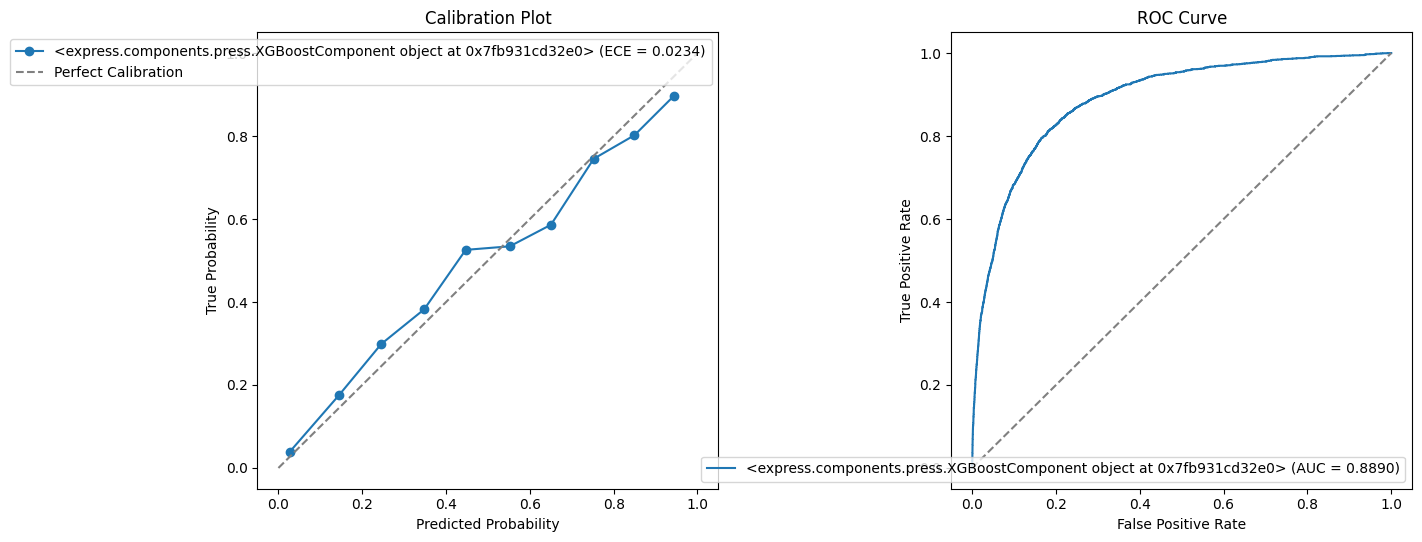

In [15]:
import torch
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, roc_auc_score
from torchmetrics.classification import BinaryCalibrationError

def plot_calibration_curves(y_true, y_pred, ax):
    bce_l1 = BinaryCalibrationError(n_bins=10, norm='l1')
    ece = bce_l1(torch.Tensor(y_pred), torch.Tensor(y_true))

    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)
    ax.plot(prob_pred, prob_true, marker='o', label=f'{model} (ECE = {ece:.4f})')

    ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Perfect Calibration')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('True Probability')
    ax.set_title('Calibration Plot')
    ax.legend()

def plot_roc_curves(y_true, y_pred, ax):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    ax.plot(fpr, tpr, label=f'{model} (AUC = {auc_score:.4f})')

    ax.plot([0, 1], [0, 1], linestyle='--', color='grey')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc='lower right')


y_pred = model.predict(dataset_test).values
y_true = test_dataset.labels["counterpress"].values

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_calibration_curves(y_true, y_pred, axes[0])
plot_roc_curves(y_true, y_pred, axes[1])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### XGBoost feature importances

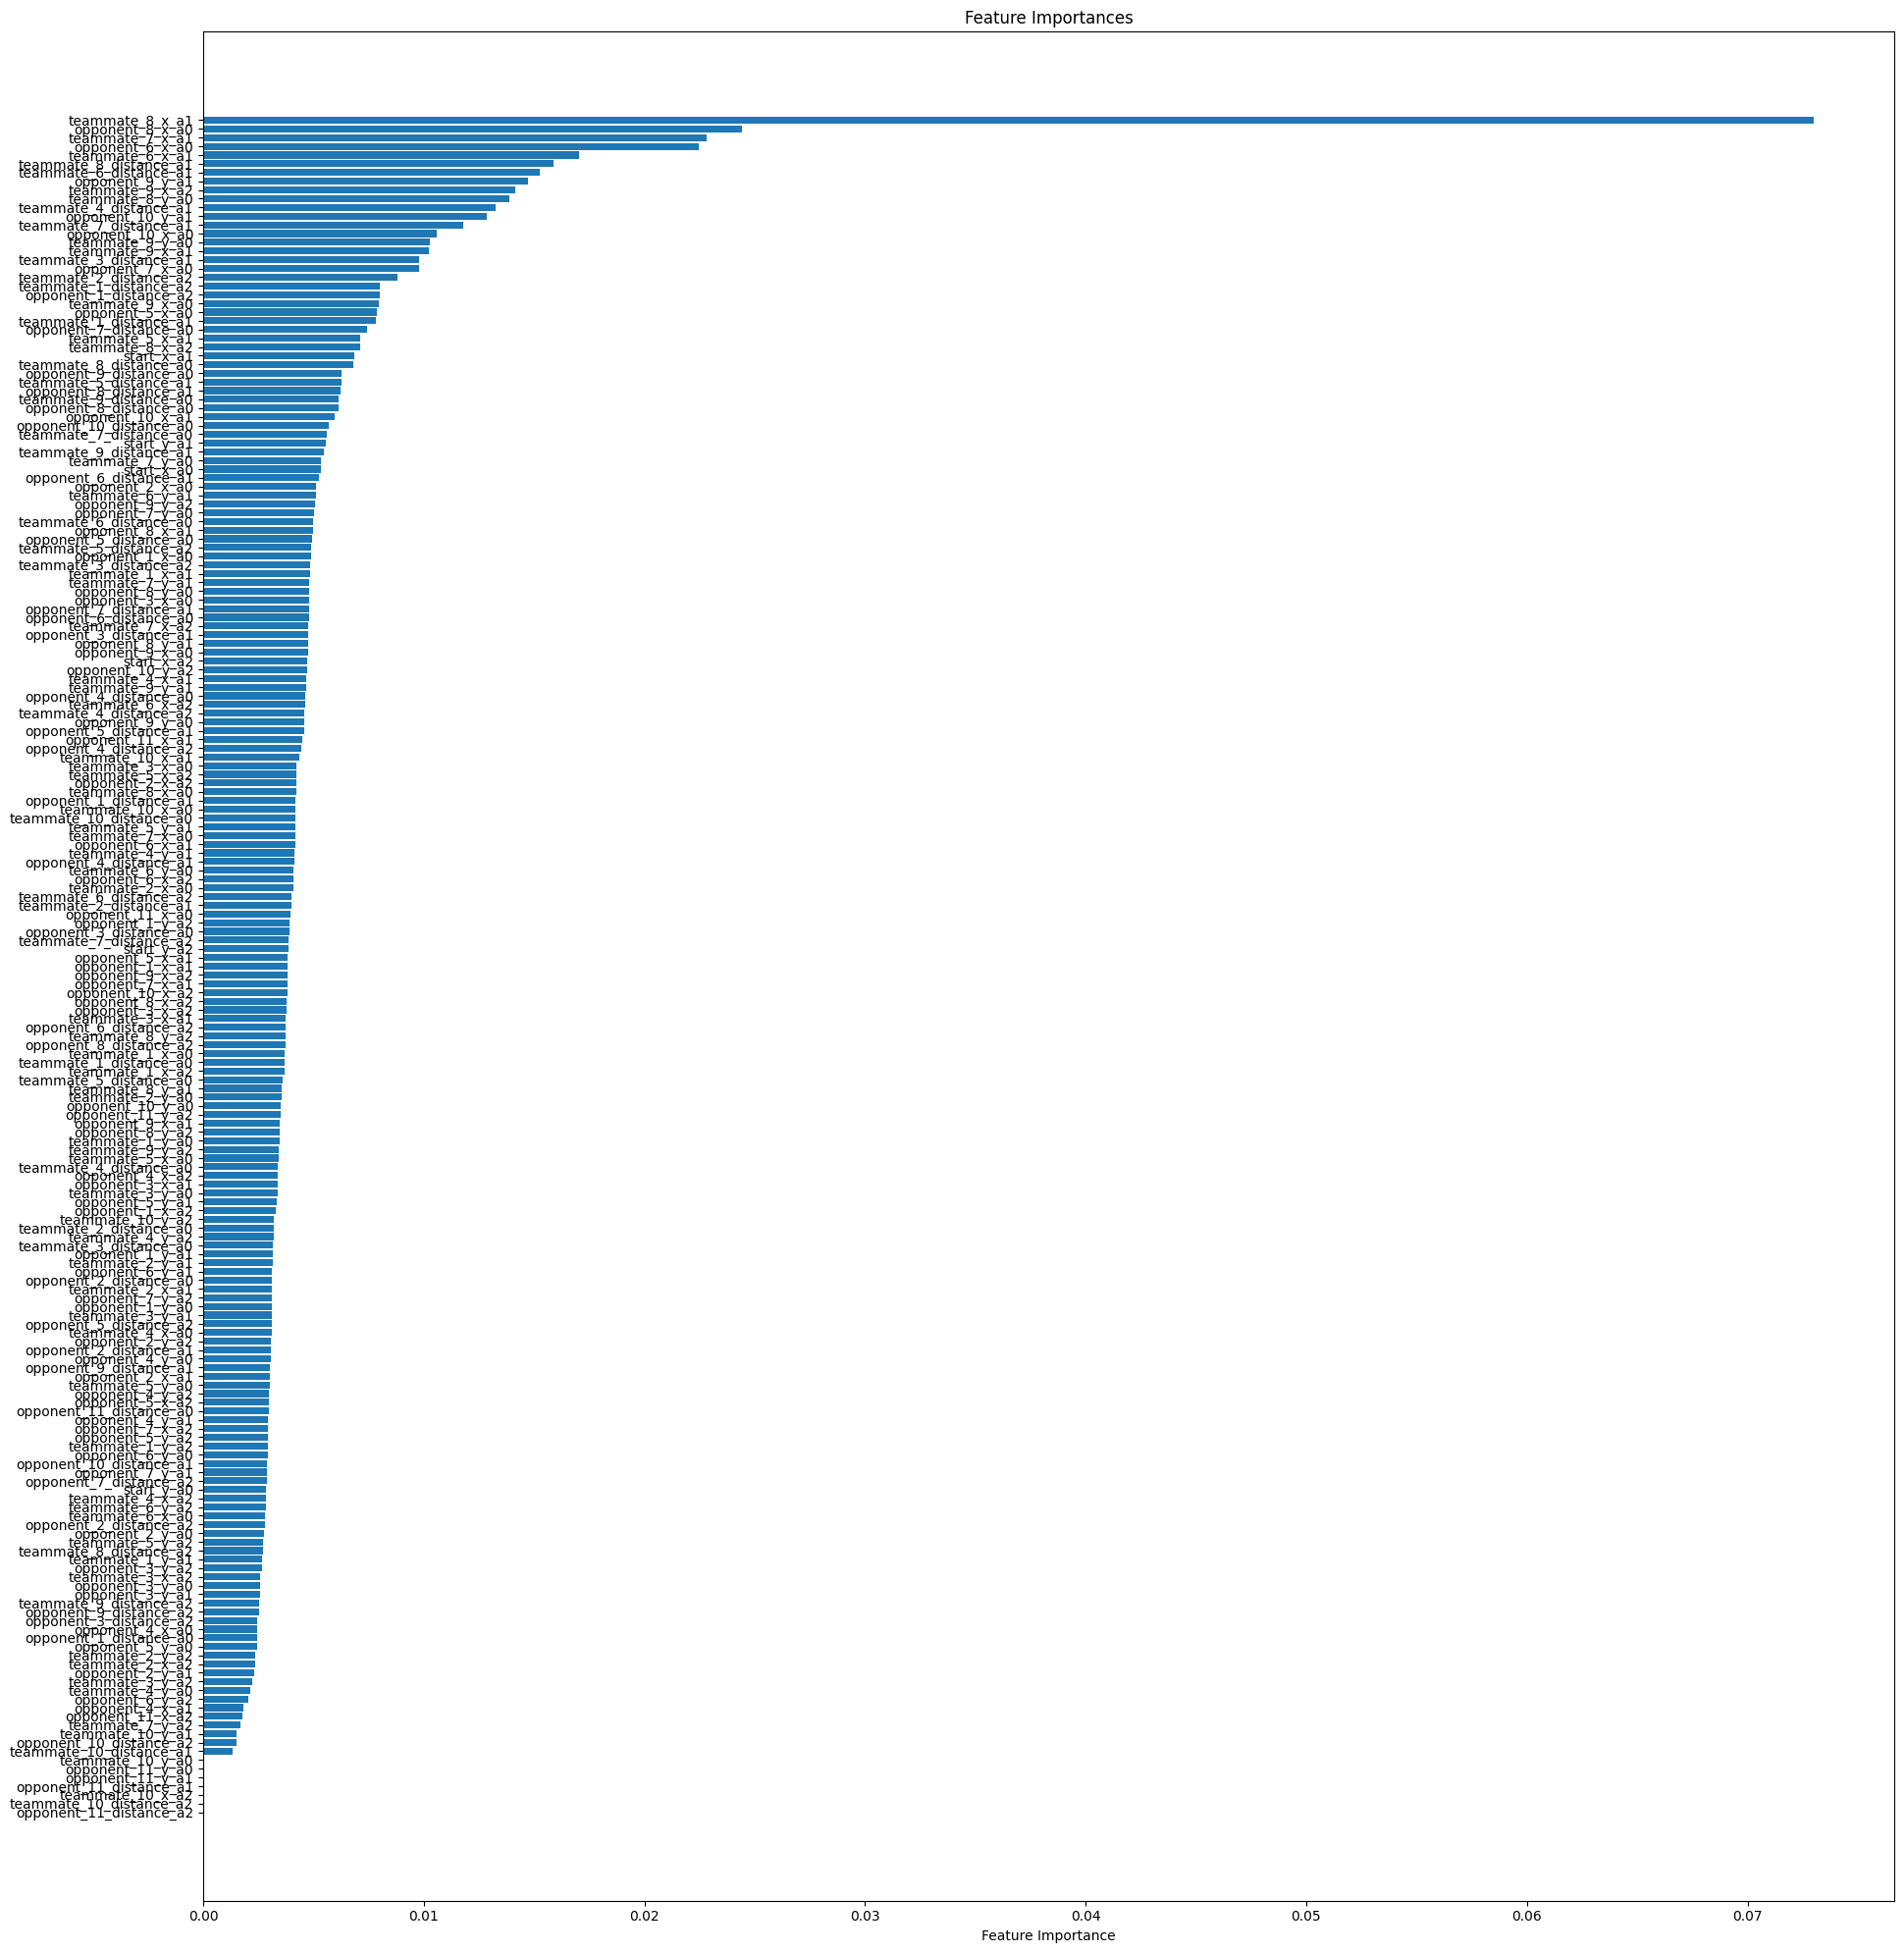

In [16]:
features = [col for _, cols in model.features.items() for col in cols]
importances = model.model.feature_importances_

# 컬럼 수에 따라 가변적인 시각화 크기 설정
num_features = len(features)
plt.figure(figsize=(max(10, num_features * 0.1), 20))  # 특징 수에 따라 증가


indices = np.argsort(importances) 
plt.barh(range(num_features), importances[indices], align='center')
plt.yticks(range(num_features), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importances')

plt.tight_layout()
plt.show()

In [18]:
game_id = 3788741

df_actions = add_names(train_db.actions(game_id)).reset_index()
df_actions.head()

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,...,play_pattern_name,under_pressure,duration,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
0,3788741,0,5c888f58-fe77-459b-ab3b-a2fa5fb8ab16,1,0.878,909,11086,52.0625,34.425,28.0000,...,From Kick Off,0,1.910504,"{'pass': {'recipient': {'id': 8963, 'name': 'C...","[[0.0, 44.39976078697438], [16.82907029647681,...",0,"[{'teammate': False, 'actor': False, 'keeper':...",pass,success,foot_right
1,3788741,1,bea4235d-7e40-461c-bb82-6d473f5bb324,1,2.789,909,8963,28.0000,43.945,31.2375,...,From Kick Off,0,1.499077,"{'carry': {'end_location': [36.2, 30.4]}}","[[30.27094296623723, 2.3520882891309185], [5.7...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",dribble,success,foot
2,3788741,2,84b9b798-0fbe-45bc-a4bf-3621959f29ce,1,4.288,909,8963,31.2375,42.585,61.4250,...,From Kick Off,0,2.476772,"{'pass': {'recipient': {'id': 8541, 'name': 'K...","[[31.00063614049526, 1.2150785249513518], [6.7...",0,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_left
3,3788741,3,6e2955cf-ad4f-4096-a4dd-053173a3802b,1,6.751,914,8286,63.2625,6.715,63.2625,...,From Kick Off,0,0.080000,{},"[[87.6897292922602, 68.0], [68.82521396005053,...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,fail,foot
4,3788741,4,1615d483-101d-45c1-b554-04cf69897232,1,6.764,909,8541,61.4250,3.995,61.1625,...,From Kick Off,1,0.101747,"{'carry': {'end_location': [70.4, 75.5]}}","[[69.32405800689574, 0.0], [40.54450680816471,...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",dribble,success,foot


### Visualization

Skip action due to missing freeze frame


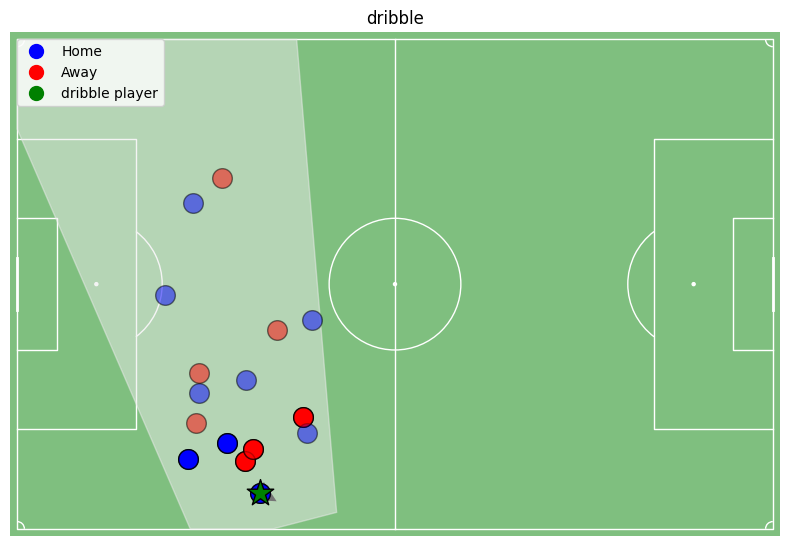

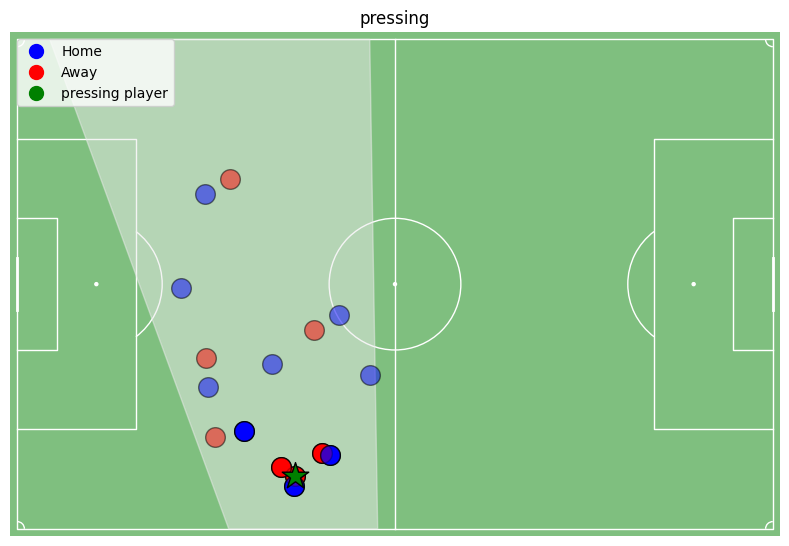

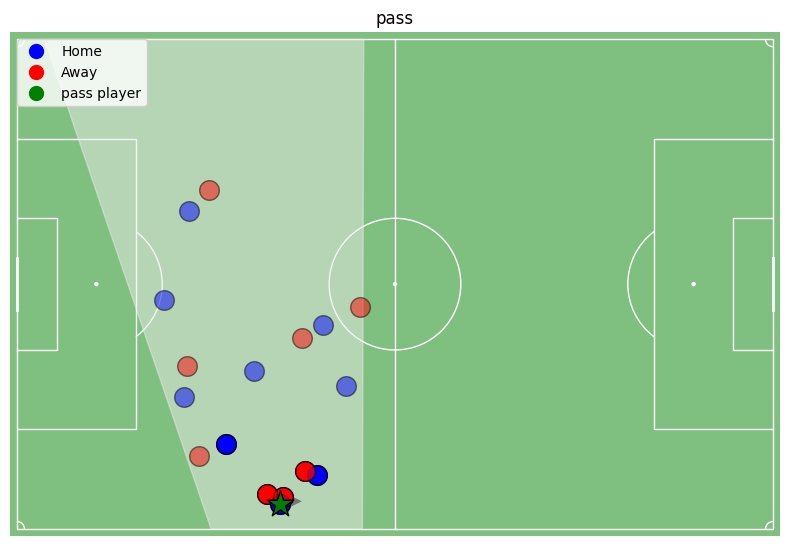

In [19]:
pressure_idx = df_actions[df_actions["type_name"] == "pressing"].index[5]
home_team_id, away_team_id = train_db.get_home_away_team_id(game_id = 3788741)
for idx in range(pressure_idx-2, pressure_idx+2):
    if df_actions.loc[idx]["freeze_frame_360"] is None:
        print("Skip action due to missing freeze frame")
        continue
    plot_action(df_actions.loc[idx], home_team_id=home_team_id)